# Single-Image Super-Resolution: FSRCNN Implementation

This is an implemetation and tutorial for the paper : "FSRCNN: Dong et al, “Accelerating the super-resolution convolutional neural network”, ECCV 2016"

Authors: <br>
Ting Wei Li (unique name: tingwl), UMID #97545879 <br>
Yi Ting Hsiao(unique name: hsiaoyt) , UMID #42070296

## Re-usage of previous course code *
If the title of a section block follows a "*" sign, then the content is mainly borrowed from the Assignment 5's python notebook that made by the instructor/staff of the course: UMich 598-008 DLCV 2022 Winter.

## Google Colab Setup *

We need to run a few commands to set up our environment on Google Colab.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Recall the path in your Google Drive where you uploaded this notebook, fill it in below. 

In [ ]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "dlcv_proj/A5"
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['General-100', 'a5_helper.py', 'rnn_lstm_attention_submission.pt', 'Transformers.ipynb', 'data', 'Urban100', 'images-91', 'Super-resolution-scaling4.ipynb', '__pycache__', 'Super-resolution.ipynb', 'BSD100', 'fsrcnn.py', 'FSRCNN.ipynb', 'Super-resolution-scaling3.ipynb']


## Load Packages *

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import math
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn
import skimage
from skimage import color
import numpy as np
from PIL import Image
import torchvision


# for plotting
%matplotlib inline
plt.style.use("seaborn")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.cmap"] = "gray"

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

# Define some common variables for dtypes/devices.
# These can be keyword arguments while defining new tensors.
to_float = {"dtype": torch.float32, "device": DEVICE}
to_double = {"dtype": torch.float64, "device": DEVICE}

Good to go!


# FSRCNN ([Fast Super-Resolution Convolutional Neural Network](https://arxiv.org/abs/1608.00367)) *



In this notebook, we will implement FSRCNN model step-by-step by referencing the original paper. We will use several datasets to train/validate/test our model.

## Table of Contents




In this notebook, we will show how to implement a CNN-based Super-Resoluation Model: FSRCNN model, in a step-by-step manner. We will first consider the case that the `scaling factor` equals to 2 in **Part I-III**, then we will consider the `scaling factor` equals to 3 in **Part IV-VI**.

1. **Part I (Training Data Preparation)**: We will preprocess Image-91 and General-100 dataset that consist of pairs of high-resolution and low-resolution images with different scaling factors. Data augmentation method that the authors used will be applied to these two datasets. Also, BSD-100 dataset is used as a validation dataset.
2. **Part II (Implement/Train FSRCNN Model)**: We will implement the core CNN model of FSRCNN. It will consist of following parts:
   1. First Part: Feature extraction
   2. Second Part: Shrinking, Mapping, Expanding Operation
   3. Last Part: Deconvolution Layer

   and the training process (training loss, validation dataset PSNR, and training curves) will also be printed and plotted.

   
3. **Part III (Build Evaluation/Inference Function)**: We will use the build-in package to compute PSNR(Peak Signal-to-Noise Ratio) and SSIM(Structural Similarity Index Measure) for our reconstructed images. Also, we will visualize the up-scaled images for each of the image in Set5 dataset and some of the images in Set14 dataset.

4. **Part IV-VI**: we repeat Part1~3 for `scaling factor` equals to 3.

5. **Part VII**: Conclusion

6. **Part VIII**: Reference

Before that, we will first load the dataset we need, inlcuding General-100, Image-91 and BSD-100 datasets. The first two datasets are for training and fine-tuning, while the last one is for validation.

In [ ]:
import os

GENERAL_100_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'General-100')

filenames_general_100 = [name for name in os.listdir(GENERAL_100_PATH) if os.path.splitext(name)[-1] == '.bmp']
print(filenames_general_100[:5])

IMAGE_91_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'images-91')

filenames_image_91 = [name for name in os.listdir(IMAGE_91_PATH) if os.path.splitext(name)[-1] == '.bmp']
print(filenames_image_91[:5])

BSD_100_PATH_2 = os.path.join(GOOGLE_DRIVE_PATH, 'BSD100/image_SRF_2')
filenames_bsd_100_2 = [name for name in os.listdir(BSD_100_PATH_2) if os.path.splitext(name)[-1] == '.png']
print(filenames_bsd_100_2[:5])

BSD_100_PATH_3 = os.path.join(GOOGLE_DRIVE_PATH, 'BSD100/image_SRF_3')
filenames_bsd_100_3 = [name for name in os.listdir(BSD_100_PATH_3) if os.path.splitext(name)[-1] == '.png']
print(filenames_bsd_100_3[:5])

['im_79.bmp', 'im_26.bmp', 'im_29.bmp', 'im_38.bmp', 'im_82.bmp']
['tt16.bmp', 'tt2.bmp', 'tt3.bmp', 't48.bmp', 't63.bmp']
['img_033_SRF_2_HR.png', 'img_024_SRF_2_HR.png', 'img_087_SRF_2_LR.png', 'img_094_SRF_2_LR.png', 'img_053_SRF_2_LR.png']
['img_025_SRF_3_LR.png', 'img_071_SRF_3_LR.png', 'img_063_SRF_3_HR.png', 'img_041_SRF_3_HR.png', 'img_037_SRF_3_LR.png']


## Color Channel Transformation

As mentioned is the mini-project instruction, our model is trained on the Y color channel only (as well as validation and evaluation). So we need to convert our input image from RGB color channels to YCbCr (or Y only) color channels first.

In [ ]:
from fsrcnn import convert_rgb2ycbcr, convert_rgb2y

sample_image_batch_rgb = torch.rand((20, 3, 112, 112)).clamp(0.0, 1.0)

# convert to YCbCr Channel
sample_image_batch_ycbcr = convert_rgb2ycbcr(sample_image_batch_rgb)
# print the shape of transformed image
print(sample_image_batch_ycbcr.shape)
# print the value range : (16, 240)
print(torch.min(sample_image_batch_ycbcr), torch.max(sample_image_batch_ycbcr))

# convert to Y channel only
sample_image_batch_y = convert_rgb2y(sample_image_batch_rgb)
# print the shape of transformed image
print(sample_image_batch_y.shape)
# print the value range of Y channel : (16, 235)
print(torch.min(sample_image_batch_y), torch.max(sample_image_batch_y))


torch.Size([20, 3, 112, 112])
tensor(17.0674) tensor(238.3661)
torch.Size([20, 1, 112, 112])
tensor(17.0674) tensor(233.3991)


## Data Augmentation

In the original paper, authors utilize a simple data augmentation method, which includes both image rotation and down-scaling.
1. Rotation: each image will be roatated by 0, 90, 180, 270 degrees.
2. Down scaling: each image will be down-scaled with the factor 1.0, 0.9, 0.8, 0.7 and 0.6.

In [ ]:
from fsrcnn import data_augmentation

# input: one single three-channel image
sample_image_rgb = torch.rand((3, 112, 112)).clamp(0.0, 1.0)
# output: (5*4) = 20 augmented images
augmented_image = data_augmentation(sample_image_rgb)
# images with different scales
print(augmented_image[0].shape)
print(augmented_image[1].shape)
print(augmented_image[2].shape)
print(augmented_image[3].shape)
print(augmented_image[4].shape)

torch.Size([3, 67, 67])
torch.Size([3, 78, 78])
torch.Size([3, 89, 89])
torch.Size([3, 100, 100])
torch.Size([3, 112, 112])


# Part I. Training Data Preparation (Scaling Factor = 2)

## Generate training dataset

For each image in the training dataset, we will first apply data augmentation. Then pathces are cropped out with the specified sizes, resulting in our training data. 

We will start from scaling factor 2, and the specified patch size is 10*10 (fixed in original paper). Here we set stride equals to patch size, which means we will not crop repeated pixels.

First we load Image-91 data and crop patches down. Note that we can vary the stride to trade-off between training data size and efficiency.

In [ ]:
from fsrcnn import crop_patch

scale_factor = 2
patch_size = 10
stride = patch_size
# list of cropped patches in high resolution
hr_patches = []
# list of cropped patches in low resolution
lr_patches = []

for idx, filename in enumerate(filenames_image_91):
    img = Image.open(os.path.join(IMAGE_91_PATH, filenames_image_91[idx]))
    img = torch.tensor(np.array(img)).float() / 255.0
    img = img.permute(2,0,1).contiguous()
    hr_images = data_augmentation(img)
    w = img.shape[1]
    h = img.shape[2]

    crop_patch(hr_images, hr_patches, lr_patches, scale_factor, patch_size, stride, w, h)


    if (idx+1) % 10 == 0:
        print("# processed images: ", idx+1)
  
  

lr_patches_train = torch.cat(lr_patches, dim=0)
hr_patches_train = torch.cat(hr_patches, dim=0)
print(lr_patches_train.shape)
print(hr_patches_train.shape)



# processed images:  10
# processed images:  20
# processed images:  30
# processed images:  40
# processed images:  50
# processed images:  60
# processed images:  70
# processed images:  80
# processed images:  90
torch.Size([246240, 1, 10, 10])
torch.Size([246240, 1, 20, 20])


Then we utilize the same function to load General-100 data also crop it into patches. Here we set stride to twice the patch size in order to get small enough data amount to process efficiently.

In [ ]:
from fsrcnn import crop_patch

scale_factor = 2
patch_size = 10
stride = int(patch_size * 2)
# list of cropped patches in high resolution
hr_patches = []
# list of cropped patches in low resolution
lr_patches = []

for idx, filename in enumerate(filenames_general_100):
    img = Image.open(os.path.join(GENERAL_100_PATH, filenames_general_100[idx]))
    img = torch.tensor(np.array(img)).float() / 255.0
    img = img.permute(2,0,1).contiguous()
    hr_images = data_augmentation(img)

    crop_patch(hr_images, hr_patches, lr_patches, scale_factor, patch_size, stride, w, h)


    if (idx+1) % 10 == 0:
        print("# processed images: ", idx+1)
  
  

lr_patches_finetune = torch.cat(lr_patches, dim=0)
hr_patches_finetune = torch.cat(hr_patches, dim=0)
print(lr_patches_finetune.shape)
print(hr_patches_finetune.shape)

# processed images:  10
# processed images:  20
# processed images:  30
# processed images:  40
# processed images:  50
# processed images:  60
# processed images:  70
# processed images:  80
# processed images:  90
# processed images:  100
torch.Size([176000, 1, 10, 10])
torch.Size([176000, 1, 20, 20])


## Load validation dataset

Now we will load our validation dataset, which is the BSD-100 dataset. This dataset contains pairs of training samples fro scaling factor 2, 3 and4.

In [ ]:
from fsrcnn import get_validate_img


val_in, val_out = get_validate_img(BSD_100_PATH_2, 2)
for img_in in range(len(val_in)):
    val_in[img_in] = convert_rgb2y(val_in[img_in]).float().unsqueeze(0) / 235.0

for img_out in range(len(val_out)):
    val_out[img_out] = convert_rgb2y(val_out[img_out]).float().unsqueeze(0) / 235.0
    
    
print("lr val data size: ", len(val_in))
print("hr val data size: ", len(val_out))

# processed images:  10
# processed images:  20
# processed images:  30
# processed images:  40
# processed images:  50
# processed images:  60
# processed images:  70
# processed images:  80
# processed images:  90
# processed images:  100
lr val data size:  100
hr val data size:  100


# Part II. Implement FSRCNN Model

We created a FSRCNN object, which aligns to the structure in the the paper. There are some variables we that we can modify for our model structure: 
- `scale_factor`: the factor that scales the model
- `num_channels`: input & output channel.  default 1.
- `m`: number of conv layers in the mapping stage. default 4.
- `d`: number of channels before shrinking. default 56.
- `s`: number of chnnels during mapping stage. default 12.

## Train the model*

We will now train the our FSRCNN model. The main backbone of this part was borrowed from previous assignments. Note that the trainig process consists of two stages:
1. train FSRCNN from scratch using Image-91 dataset. Update parameters of the entire model.
2. finetune the entire model using General-100 dataset.

We plot the loss curve / validation PSNR during our training process to show our work. Note that before we put the Y-channel into the model, we will normalize the input by dividing them by 235. 

In [ ]:
# we rename our training sample pairs

train_data_gt_ycbcr = hr_patches_train
print("training data gt shape: ", train_data_gt_ycbcr.shape)

train_data_input_ycbcr = lr_patches_train
print("training data input shape: ", train_data_input_ycbcr.shape)

training data gt shape:  torch.Size([246240, 1, 20, 20])
training data input shape:  torch.Size([246240, 1, 10, 10])


## Tune the parameters
In this part, we will tune `epoch` and `batch_size`  to find our best model.
(default: epoch=50, batch_size=64)

In [ ]:
from fsrcnn import train_super_resolution

# for ranadom permutation
idx = torch.randperm(train_data_input_ycbcr.shape[0])

train_data_input_ycbcr_sh  = train_data_input_ycbcr[idx]
# normalize the Y channel data
train_data_input_ycbcr_sh = train_data_input_ycbcr_sh / 235.0

train_data_gt_ycbcr_sh  = train_data_gt_ycbcr[idx]
# normalize the Y channel data
train_data_gt_ycbcr_sh  = train_data_gt_ycbcr_sh  / 235.0


torch.Size([246240, 1, 10, 10])
torch.Size([246240, 1, 20, 20])


learning rate is:  0.001
(Epoch 0 / 50) train loss: 0.000787 val PSNR: 27.516953 time per epoch: 19.0s
(Epoch 1 / 50) train loss: 0.000668 val PSNR: 27.660074 time per epoch: 19.3s
(Epoch 2 / 50) train loss: 0.000628 val PSNR: 27.829897 time per epoch: 19.1s
(Epoch 3 / 50) train loss: 0.000581 val PSNR: 27.869120 time per epoch: 19.0s
(Epoch 4 / 50) train loss: 0.000561 val PSNR: 27.923098 time per epoch: 19.3s
(Epoch 5 / 50) train loss: 0.000548 val PSNR: 27.956686 time per epoch: 19.1s
(Epoch 6 / 50) train loss: 0.000528 val PSNR: 28.022770 time per epoch: 19.1s
(Epoch 7 / 50) train loss: 0.000513 val PSNR: 28.056353 time per epoch: 19.3s
(Epoch 8 / 50) train loss: 0.000502 val PSNR: 28.069250 time per epoch: 19.3s
(Epoch 9 / 50) train loss: 0.000491 val PSNR: 28.078964 time per epoch: 19.0s
(Epoch 10 / 50) train loss: 0.000485 val PSNR: 28.071541 time per epoch: 19.0s
(Epoch 11 / 50) train loss: 0.000487 val PSNR: 28.070778 time per epoch: 19.2s
(Epoch 12 / 50) train loss: 0.000490 

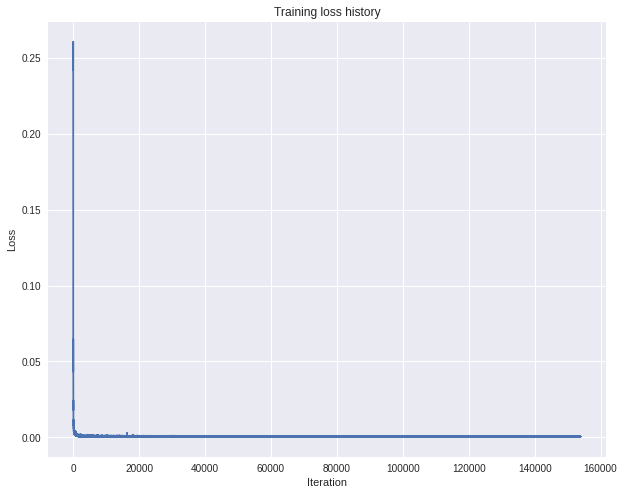

In [ ]:
from fsrcnn import FSRCNN
fsrcnn = FSRCNN(scale_factor=2, dtype=train_data_input_ycbcr.dtype, device=torch.device("cuda"))
# num_epochs = 50
# ovr_batch_size = 100
num_epochs = 50
ovr_batch_size = 80


for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    sr_overfit, _ = train_super_resolution(
        fsrcnn,
        training_data=train_data_input_ycbcr_sh,
        gt_data=train_data_gt_ycbcr_sh,
        val_data=val_in,
        val_gt_data=val_out,
        scale_factor=2,
        num_epochs=num_epochs,
        batch_size=ovr_batch_size,
        learning_rate=learning_rate,
        from_scratch=True,
        device="cuda",
    )


Following the original paper, after we train our FSRCNN model using Image-91 dataset from scratch, General-100 dataset will be used for further fine-turning. We lower down our learning rate to half of which we used in the previous phase.

In [ ]:
train_data_gt_ycbcr_finetune = hr_patches_finetune
# train_data_gt = data_dict["train_images"][:num_training_data].float() / 256.0

print("training data gt shape: ", train_data_gt_ycbcr_finetune.shape)

# downsampling to produce training data
train_data_input_ycbcr_finetune = lr_patches_finetune

print("training data input shape: ", train_data_input_ycbcr_finetune.shape)

training data gt shape:  torch.Size([176000, 1, 20, 20])
training data input shape:  torch.Size([176000, 1, 10, 10])


learning rate is:  0.0005
(Epoch 0 / 30) train loss: 0.000552 val PSNR: 28.082125 time per epoch: 3.5s
(Epoch 1 / 30) train loss: 0.000551 val PSNR: 28.078730 time per epoch: 3.4s
(Epoch 2 / 30) train loss: 0.000550 val PSNR: 28.077230 time per epoch: 3.4s
(Epoch 3 / 30) train loss: 0.000549 val PSNR: 28.076324 time per epoch: 3.4s
(Epoch 4 / 30) train loss: 0.000549 val PSNR: 28.075699 time per epoch: 3.4s
(Epoch 5 / 30) train loss: 0.000549 val PSNR: 28.075241 time per epoch: 3.4s
(Epoch 6 / 30) train loss: 0.000549 val PSNR: 28.074890 time per epoch: 3.4s
(Epoch 7 / 30) train loss: 0.000548 val PSNR: 28.074608 time per epoch: 3.4s
(Epoch 8 / 30) train loss: 0.000548 val PSNR: 28.074375 time per epoch: 3.6s
(Epoch 9 / 30) train loss: 0.000548 val PSNR: 28.074177 time per epoch: 3.4s
(Epoch 10 / 30) train loss: 0.000548 val PSNR: 28.074001 time per epoch: 3.4s
(Epoch 11 / 30) train loss: 0.000548 val PSNR: 28.073853 time per epoch: 3.4s
(Epoch 12 / 30) train loss: 0.000548 val PSNR: 2

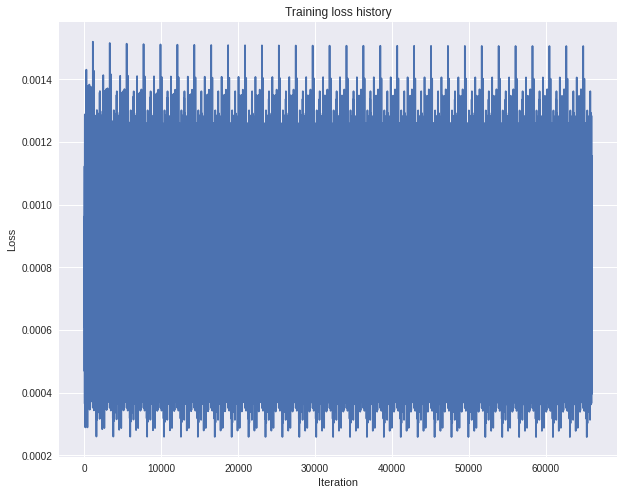

In [ ]:
# train_data_input_ycbcr_finetune = train_data_input_ycbcr_finetune.to("cuda")
idx1 = torch.randperm(train_data_input_ycbcr_finetune.shape[0])
train_data_input_ycbcr_finetune_sh  = train_data_input_ycbcr_finetune[idx1]
train_data_input_ycbcr_finetune_sh = train_data_input_ycbcr_finetune_sh / 235.0

# train_data_gt_ycbcr_finetune = train_data_gt_ycbcr_finetune.to("cuda")
train_data_gt_ycbcr_finetune_sh  = train_data_gt_ycbcr_finetune[idx1]
train_data_gt_ycbcr_finetune_sh = train_data_gt_ycbcr_finetune_sh / 235.0

num_epochs = 30
ovr_batch_size = 80


for learning_rate in [5e-4]:
    print("learning rate is: ", learning_rate)
    sr_overfit, _ = train_super_resolution(
        fsrcnn,
        training_data=train_data_input_ycbcr_finetune_sh,
        gt_data=train_data_gt_ycbcr_finetune_sh,
        val_data=val_in,
        val_gt_data=val_out,
        scale_factor=2,
        num_epochs=num_epochs,
        batch_size=ovr_batch_size,
        learning_rate=learning_rate,
        from_scratch=True,
        device="cuda",
    )

# Part III. Evaluation and Inference 

For the evaluation, we will use Set5 and Set14 dataset to evaluate our model performances using the following two evaluation metrics: **PSNR** and **SSIM**.

Firstly, we will load our testing datasets.

In [ ]:
from fsrcnn import get_eval_img_set5, get_eval_img_set14
scaling_factor = 2
if scaling_factor == 2:
    SET5_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set5', 'image_SRF_2')
    SET14_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set14', 'image_SRF_2')
elif scaling_factor == 3:
    SET5_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set5', 'image_SRF_3')
    SET14_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set14', 'image_SRF_3')


eval_in_set5, eval_out_set5 = get_eval_img_set5(SET5_PATH, scaling_factor)
eval_in_set14, eval_out_set14 = get_eval_img_set14(SET14_PATH, scaling_factor)

print(len(eval_in_set5), len(eval_out_set5))
print(len(eval_in_set14), len(eval_out_set14))


5 5
14 14


The performance of our FSRCNN model will compare with two baseline models: **bilinear** and **bicubic**.

In [ ]:
# test on set5 / set14 data
from fsrcnn import inference
from fsrcnn import eval_model
import torchvision

lpsnr = 0.0
lssim = 0.0
cpsnr = 0.0
cssim = 0.0
fpsnr = 0.0
fssim = 0.0
num_test = 5


bilinear_recon = []
bicubic_recon = []
fsrcnn_recon = []

for i in range(num_test):
  
    evaluate_data = eval_out_set5[i].permute(1,2,0).contiguous().float() / 255.0
    evaluate_data = torch.from_numpy(skimage.color.rgb2ycbcr(evaluate_data))[:,:,0] 
    # evaluate_data = convert_rgb2y(eval_out_set5[i]).squeeze(0)
    evaluate_data_input = eval_in_set5[i].unsqueeze(0).float() / 255.0
    
    
    # bilinear
    bilinear_rebuild, bilinear_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bilinear', 2)
    bilinear_rebuild = bilinear_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, bilinear_rebuild)
    lpsnr += fig_psnr / num_test
    lssim += fig_ssim / num_test
    bilinear_recon.append(bilinear_rgb_image.clamp(0.0,1.0))
    
    
    #bicubic_rebuild = baseline_bicubic(evaluate_data_input, evaluate_data_input.dtype).squeeze(0).permute(1,2,0).contiguous().clamp(0.0,1.0)
    bicubic_rebuild, bicubic_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bicubic', 2)
    bicubic_rebuild = bicubic_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, bicubic_rebuild)
    cpsnr += fig_psnr / num_test
    cssim += fig_ssim / num_test
    bicubic_recon.append(bicubic_rgb_image.clamp(0.0,1.0))
    
    
    fsrcnn_rebuild, fsrcnn_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'fsrcnn', 2)
    fsrcnn_rebuild = fsrcnn_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, fsrcnn_rebuild)
    fpsnr += fig_psnr / num_test
    fssim += fig_ssim / num_test
    fsrcnn_recon.append(fsrcnn_rgb_image.clamp(0.0,1.0))
print("--------Evaluation Results on Set5 Dataset--------")
print("bilinear mean psnr: ", lpsnr)
print("bilinear mean ssim: ", lssim)
print("bicubic mean psnr: ", cpsnr)
print("bicubic mean ssim: ", cssim)
print("fsrcnn mean psnr: ", fpsnr)
print("fsrcnn mean ssim: ", fssim)


--------Evaluation Results on Set5 Dataset--------
bilinear mean psnr:  32.27107410423122
bilinear mean ssim:  0.9118253363879878
bicubic mean psnr:  33.969223792200346
bicubic mean ssim:  0.9329743671030556
fsrcnn mean psnr:  35.04994091018395
fsrcnn mean ssim:  0.9425432614898887


We can see that our trained FSRCNN model outperforms bilinear nad bicubic baselines under both evaludatoin metrics. Also, the PSNR value of our model exceeds the desired threshold: 34.0dB. 

Now we evaluate our FSRCNN model on Set14 dataset.

We can still observe supremacy of our FSRCNN model.

In [ ]:
# test on set5 / set14 data
from fsrcnn import inference
from fsrcnn import eval_model
import torchvision

lpsnr = 0.0
lssim = 0.0
cpsnr = 0.0
cssim = 0.0
fpsnr = 0.0
fssim = 0.0
num_test = 14


bilinear_recon = []
bicubic_recon = []
fsrcnn_recon = []

for i in range(num_test):
  
    evaluate_data = eval_out_set14[i].permute(1,2,0).contiguous().float() / 255.0
    evaluate_data = torch.from_numpy(skimage.color.rgb2ycbcr(evaluate_data))[:,:,0] 
    # evaluate_data = convert_rgb2y(eval_out_set5[i]).squeeze(0)
    evaluate_data_input = eval_in_set14[i].unsqueeze(0).float() / 255.0
    
    
    # bilinear
    bilinear_rebuild, bilinear_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bilinear')
    bilinear_rebuild = bilinear_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, bilinear_rebuild)
    lpsnr += fig_psnr / num_test
    lssim += fig_ssim / num_test
    bilinear_recon.append(bilinear_rgb_image.clamp(0.0,1.0))
    
    
    #bicubic_rebuild = baseline_bicubic(evaluate_data_input, evaluate_data_input.dtype).squeeze(0).permute(1,2,0).contiguous().clamp(0.0,1.0)
    bicubic_rebuild, bicubic_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bicubic')
    bicubic_rebuild = bicubic_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, bicubic_rebuild)
    cpsnr += fig_psnr / num_test
    cssim += fig_ssim / num_test
    bicubic_recon.append(bicubic_rgb_image.clamp(0.0,1.0))
    
    
    fsrcnn_rebuild, fsrcnn_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'fsrcnn')
    fsrcnn_rebuild = fsrcnn_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, fsrcnn_rebuild)
    fpsnr += fig_psnr / num_test
    fssim += fig_ssim / num_test
    fsrcnn_recon.append(fsrcnn_rgb_image.clamp(0.0,1.0))
print("--------Evaluation Results on Set14 Dataset--------")
print("bilinear mean psnr: ", lpsnr)
print("bilinear mean ssim: ", lssim)
print("bicubic mean psnr: ", cpsnr)
print("bicubic mean ssim: ", cssim)
print("fsrcnn mean psnr: ", fpsnr)
print("fsrcnn mean ssim: ", fssim)


--------Evaluation Results on Set14 Dataset--------
bilinear mean psnr:  29.05276444107892
bilinear mean ssim:  0.8407494532419015
bicubic mean psnr:  30.321486030084692
bicubic mean ssim:  0.8750408741801812
fsrcnn mean psnr:  31.08543030530224
fsrcnn mean ssim:  0.8843284575411386


After we found the best model, the following code allows us to save it for future reference.

In [ ]:
# save model!!!!
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "dlcv_proj"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
model_path = "fsrcnn_model_scale2.pth"
model_path = os.path.join(GOOGLE_DRIVE_PATH, model_path)
torch.save(fsrcnn.to("cpu").state_dict(), model_path)
            
fsrcnn = fsrcnn.to("cuda")
print("model saved!!")


model saved!!


After we train and save the model and compute the evaluation metric, let's visualize our result.

In [ ]:
#Show Set5 images examples


for i in range(num_test):
    fig = plt.figure(figsize=(18, 16), dpi=80)

    ax = plt.subplot("151")
    ax.imshow(eval_in_set5[i].permute(1, 2, 0))
    ax.set_title("Low-Resolution Image")
    ax.axis("off")

    ax = plt.subplot("152")
    ax.imshow(eval_out_set5[i].permute(1, 2, 0))
    ax.set_title("Ground Truth Image")
    ax.axis("off")

    ax = plt.subplot("153")
    ax.imshow(bilinear_recon[i].permute(1, 2, 0))
    ax.set_title("Bilinear Reconstuction")
    ax.axis("off")

    ax = plt.subplot("154")
    ax.imshow(bicubic_recon[i].permute(1, 2, 0))
    ax.set_title("Bicubic Reconstruction")
    ax.axis("off")

    ax = plt.subplot("155")
    ax.imshow(fsrcnn_recon[i].permute(1, 2, 0))
    ax.set_title("FSRCNN Reconstruction")
    ax.axis("off")


plt.show()


Output hidden; open in https://colab.research.google.com to view.

We can also visualize some of the reconstructed images in Set14 dataset.

In [ ]:
#Show Set14 images examples


for i in range(5):
    fig = plt.figure(figsize=(18, 16), dpi=80)

    ax = plt.subplot("151")
    ax.imshow(eval_in_set14[i].permute(1, 2, 0))
    ax.set_title("Low-Resolution Image")
    ax.axis("off")

    ax = plt.subplot("152")
    ax.imshow(eval_out_set14[i].permute(1, 2, 0))
    ax.set_title("Ground Truth Image")
    ax.axis("off")

    ax = plt.subplot("153")
    ax.imshow(bilinear_recon[i].permute(1, 2, 0))
    ax.set_title("Bilinear Reconstuction")
    ax.axis("off")

    ax = plt.subplot("154")
    ax.imshow(bicubic_recon[i].permute(1, 2, 0))
    ax.set_title("Bicubic Reconstruction")
    ax.axis("off")

    ax = plt.subplot("155")
    ax.imshow(fsrcnn_recon[i].permute(1, 2, 0))
    ax.set_title("FSRCNN Reconstruction")
    ax.axis("off")


plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Part IV. Training Data Preparation (Scaling Factor = 3)

The part for scaling factor 2 is completed, now we will turn to the case that scaling factor equals to 3. Part 4-6 will be a duplicate of Part 1-3.

## Generate training dataset

For each image in the training dataset, we will first apply data augmentation. Then patches are cropped out with the specified sizes, resulting in our training data. 

Now we use scaling factor = 3, and the specified patch size is 7*7 (fixed in original paper). Here we set stride equals to patch size, which means we will not crop repeated pixels.

First we load Image-91 data and crop patches. Note that we can vary the stride to trade-off between training data size and efficiency.

In [ ]:
from fsrcnn import crop_patch

scale_factor = 3
patch_size = 7
stride = patch_size
# list of cropped patches in high resolution
hr_patches = []
# list of cropped patches in low resolution
lr_patches = []

for idx, filename in enumerate(filenames_image_91):
    img = Image.open(os.path.join(IMAGE_91_PATH, filenames_image_91[idx]))
    img = torch.tensor(np.array(img)).float() / 255.0
    img = img.permute(2,0,1).contiguous()
    hr_images = data_augmentation(img)
    w = img.shape[1]
    h = img.shape[2]

    crop_patch(hr_images, hr_patches, lr_patches, scale_factor, patch_size, stride, w, h)


    if (idx+1) % 10 == 0:
        print("# processed images: ", idx+1)
  
  

lr_patches_train = torch.cat(lr_patches, dim=0)
hr_patches_train = torch.cat(hr_patches, dim=0)
print(lr_patches_train.shape)
print(hr_patches_train.shape)



# processed images:  10
# processed images:  20
# processed images:  30
# processed images:  40
# processed images:  50
# processed images:  60
# processed images:  70
# processed images:  80
# processed images:  90
torch.Size([222860, 1, 7, 7])
torch.Size([222860, 1, 21, 21])


Then we utilize the same function to load General-100 data also crop it into patches. Here we set stride to twice the patch size in order to get small enough data amount to process efficiently.

In [ ]:
from fsrcnn import crop_patch

scale_factor = 3
patch_size = 7
stride = int(patch_size * 2)
# list of cropped patches in high resolution
hr_patches = []
# list of cropped patches in low resolution
lr_patches = []

for idx, filename in enumerate(filenames_general_100):
    img = Image.open(os.path.join(GENERAL_100_PATH, filenames_general_100[idx]))
    img = torch.tensor(np.array(img)).float() / 255.0
    img = img.permute(2,0,1).contiguous()
    hr_images = data_augmentation(img)

    crop_patch(hr_images, hr_patches, lr_patches, scale_factor, patch_size, stride, w, h)


    if (idx+1) % 10 == 0:
        print("# processed images: ", idx+1)
  
  

lr_patches_finetune = torch.cat(lr_patches, dim=0)
hr_patches_finetune = torch.cat(hr_patches, dim=0)
print(lr_patches_finetune.shape)
print(hr_patches_finetune.shape)

# processed images:  10
# processed images:  20
# processed images:  30
# processed images:  40
# processed images:  50
# processed images:  60
# processed images:  70
# processed images:  80
# processed images:  90
# processed images:  100
torch.Size([160000, 1, 7, 7])
torch.Size([160000, 1, 21, 21])


## Load validation dataset

Now we will load our validation dataset, which is the BSD-100 dataset. This dataset contains pairs of training samples fro scaling factor 2, 3 and 4.

In [ ]:
from fsrcnn import get_validate_img


val_in, val_out = get_validate_img(BSD_100_PATH_3, 3)
for img_in in range(len(val_in)):
    val_in[img_in] = convert_rgb2y(val_in[img_in]).float().unsqueeze(0) / 235.0

for img_out in range(len(val_out)):
    val_out[img_out] = convert_rgb2y(val_out[img_out]).float().unsqueeze(0) / 235.0
    
    
print("lr val data size: ", len(val_in))
print("hr val data size: ", len(val_out))

# processed images:  10
# processed images:  20
# processed images:  30
# processed images:  40
# processed images:  50
# processed images:  60
# processed images:  70
# processed images:  80
# processed images:  90
# processed images:  100
lr val data size:  100
hr val data size:  100


# Part V. Implement FSRCNN Model

We created a FSRCNN object, which aligns to the structure in the the paper. There are some variables we that we can modify for our model structure: 
- `scale_factor`: the factor that scales the model
- `num_channels`: input & output channel.  default 1.
- `m`: number of conv layers in the mapping stage. default 4.
- `d`: number of channels before shrinking. default 56.
- `s`: number of chnnels during mapping stage. default 12.

## Train the model*

We will now train the our FSRCNN model. The main backbone of this part was borrowed from previous assignments. Note that the trainig process consists of two stages:
1. train FSRCNN using Image-91 dataset. Update parameters of the whole model.
2. fine tuning using General-100 dataset. Update parameters in the last part of the model(i.e. deconvolution layer).

We plot the loss during our training process to show our work. Note that before we put the Y-channel into the model, we will normalize the input by dividing them by 235. 

In [ ]:
# we rename our training sample pairs

train_data_gt_ycbcr = hr_patches_train
print("training data gt shape: ", train_data_gt_ycbcr.shape)

train_data_input_ycbcr = lr_patches_train
print("training data input shape: ", train_data_input_ycbcr.shape)

training data gt shape:  torch.Size([222860, 1, 21, 21])
training data input shape:  torch.Size([222860, 1, 7, 7])


## Tune the parameters
In this part, we will tune `epoch` and `batch_size`  to find our best model.
(default: epoch=50, batch_size=64)

In [ ]:
from fsrcnn import train_super_resolution

# for ranadom permutation
idx = torch.randperm(train_data_input_ycbcr.shape[0])

train_data_input_ycbcr_sh  = train_data_input_ycbcr[idx]
# normalize the Y channel data
train_data_input_ycbcr_sh = train_data_input_ycbcr_sh / 235.0

train_data_gt_ycbcr_sh  = train_data_gt_ycbcr[idx]
# normalize the Y channel data
train_data_gt_ycbcr_sh  = train_data_gt_ycbcr_sh  / 235.0


learning rate is:  0.001
(Epoch 0 / 40) train loss: 0.002221 val PSNR: 24.879482 time per epoch: 20.7s
(Epoch 1 / 40) train loss: 0.002179 val PSNR: 25.079010 time per epoch: 20.8s
(Epoch 2 / 40) train loss: 0.002116 val PSNR: 25.195551 time per epoch: 21.0s
(Epoch 3 / 40) train loss: 0.002060 val PSNR: 25.265385 time per epoch: 20.8s
(Epoch 4 / 40) train loss: 0.002009 val PSNR: 25.370403 time per epoch: 20.6s
(Epoch 5 / 40) train loss: 0.001998 val PSNR: 25.402391 time per epoch: 20.9s
(Epoch 6 / 40) train loss: 0.001977 val PSNR: 25.405474 time per epoch: 21.0s
(Epoch 7 / 40) train loss: 0.001942 val PSNR: 25.425928 time per epoch: 20.8s
(Epoch 8 / 40) train loss: 0.001935 val PSNR: 25.430557 time per epoch: 20.9s
(Epoch 9 / 40) train loss: 0.001923 val PSNR: 25.434658 time per epoch: 20.6s
(Epoch 10 / 40) train loss: 0.001918 val PSNR: 25.431469 time per epoch: 21.0s
(Epoch 11 / 40) train loss: 0.001909 val PSNR: 25.441414 time per epoch: 20.8s
(Epoch 12 / 40) train loss: 0.001911 

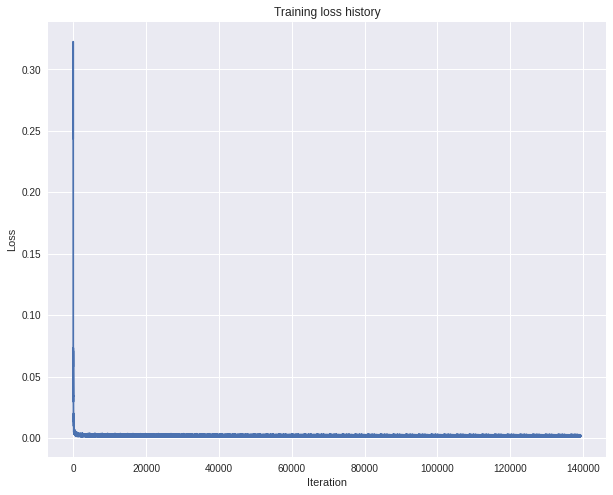

In [ ]:
from fsrcnn import FSRCNN
fsrcnn = FSRCNN(scale_factor=3, dtype=train_data_input_ycbcr.dtype, device=torch.device("cuda"))
num_epochs = 40
ovr_batch_size = 64



for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    sr_overfit, _ = train_super_resolution(
        fsrcnn,
        training_data=train_data_input_ycbcr_sh,
        gt_data=train_data_gt_ycbcr_sh,
        val_data=val_in,
        val_gt_data=val_out,
        scale_factor=3,
        num_epochs=num_epochs,
        batch_size=ovr_batch_size,
        learning_rate=learning_rate,
        from_scratch=True,
        device="cuda",
    )



Following the original paper, after we train our FSRCNN model using Image-91 dataset from scratch, General-100 dataset will be used for further fine-turning. We lower down our learning rate to half of which we used before.

In [ ]:
train_data_gt_ycbcr_finetune = hr_patches_finetune
# train_data_gt = data_dict["train_images"][:num_training_data].float() / 256.0

print("training data gt shape: ", train_data_gt_ycbcr_finetune.shape)

# downsampling to produce training data
train_data_input_ycbcr_finetune = lr_patches_finetune

print("training data input shape: ", train_data_input_ycbcr_finetune.shape)

training data gt shape:  torch.Size([160000, 1, 21, 21])
training data input shape:  torch.Size([160000, 1, 7, 7])


learning rate is:  0.0005
(Epoch 0 / 30) train loss: 0.001096 val PSNR: 25.414848 time per epoch: 15.0s
(Epoch 1 / 30) train loss: 0.001072 val PSNR: 25.403263 time per epoch: 15.0s
(Epoch 2 / 30) train loss: 0.001068 val PSNR: 25.410057 time per epoch: 14.9s
(Epoch 3 / 30) train loss: 0.001065 val PSNR: 25.416363 time per epoch: 14.9s
(Epoch 4 / 30) train loss: 0.001059 val PSNR: 25.421741 time per epoch: 15.0s
(Epoch 5 / 30) train loss: 0.001058 val PSNR: 25.434992 time per epoch: 15.0s
(Epoch 6 / 30) train loss: 0.001052 val PSNR: 25.430969 time per epoch: 14.9s
(Epoch 7 / 30) train loss: 0.001066 val PSNR: 25.422642 time per epoch: 15.0s
(Epoch 8 / 30) train loss: 0.001066 val PSNR: 25.425842 time per epoch: 14.9s
(Epoch 9 / 30) train loss: 0.001053 val PSNR: 25.423485 time per epoch: 15.1s
(Epoch 10 / 30) train loss: 0.001049 val PSNR: 25.432030 time per epoch: 15.0s
(Epoch 11 / 30) train loss: 0.001066 val PSNR: 25.427485 time per epoch: 14.9s
(Epoch 12 / 30) train loss: 0.001058

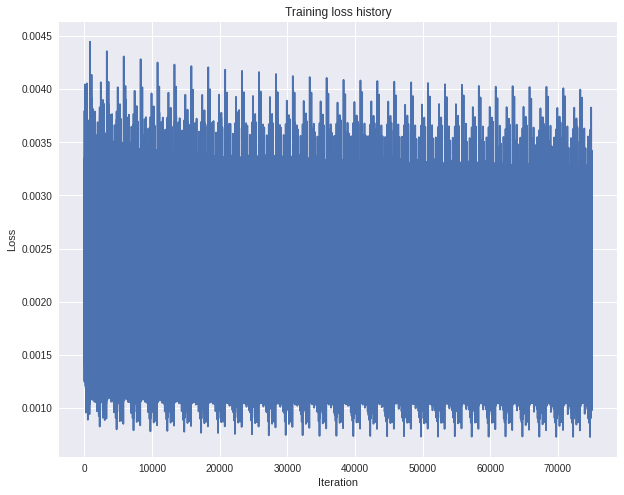

In [ ]:
# train_data_input_ycbcr_finetune = train_data_input_ycbcr_finetune.to("cuda")
idx1 = torch.randperm(train_data_input_ycbcr_finetune.shape[0])
train_data_input_ycbcr_finetune_sh  = train_data_input_ycbcr_finetune[idx1]
train_data_input_ycbcr_finetune_sh = train_data_input_ycbcr_finetune_sh / 235.0

# train_data_gt_ycbcr_finetune = train_data_gt_ycbcr_finetune.to("cuda")
train_data_gt_ycbcr_finetune_sh  = train_data_gt_ycbcr_finetune[idx1]
train_data_gt_ycbcr_finetune_sh = train_data_gt_ycbcr_finetune_sh / 235.0

num_epochs = 30
ovr_batch_size = 64


for learning_rate in [5e-4]:
    print("learning rate is: ", learning_rate)
    sr_overfit, _ = train_super_resolution(
        fsrcnn,
        training_data=train_data_input_ycbcr_finetune_sh,
        gt_data=train_data_gt_ycbcr_finetune_sh,
        val_data=val_in,
        val_gt_data=val_out,
        scale_factor=3,
        num_epochs=num_epochs,
        batch_size=ovr_batch_size,
        learning_rate=learning_rate,
        from_scratch=True,
        device="cuda",
    )

# Part VI. Evaluation and Inference 

For the evaluation, we will use Set5 and Set14 dataset to evaluate our model performances using the following two evaluation metrics: **PSNR** and **SSIM**.

Firstly, we will load our datasets.

In [ ]:
from fsrcnn import get_eval_img_set5, get_eval_img_set14
scaling_factor = 3
if scaling_factor == 2:
    SET5_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set5', 'image_SRF_2')
    SET14_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set14', 'image_SRF_2')
elif scaling_factor == 3:
    SET5_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set5', 'image_SRF_3')
    SET14_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', 'Set14', 'image_SRF_3')


eval_in_set5, eval_out_set5 = get_eval_img_set5(SET5_PATH, scaling_factor)
eval_in_set14, eval_out_set14 = get_eval_img_set14(SET14_PATH, scaling_factor)

print(len(eval_in_set5), len(eval_out_set5))
print(len(eval_in_set14), len(eval_out_set14))


5 5
14 14


The performance of our FSRCNN model will compare with two baseline models: **bilinear** and **bicubic**.

In [ ]:
# test on set5 data
from fsrcnn import eval_model
import torchvision

lpsnr = 0.0
lssim = 0.0
cpsnr = 0.0
cssim = 0.0
fpsnr = 0.0
fssim = 0.0
num_test = 5


bilinear_recon = []
bicubic_recon = []
fsrcnn_recon = []

for i in range(num_test):
  
  evaluate_data = eval_out_set5[i].permute(1,2,0).contiguous().float() / 255.0
  evaluate_data = torch.from_numpy(skimage.color.rgb2ycbcr(evaluate_data))[:,:,0] 
  
  evaluate_data_input = eval_in_set5[i].unsqueeze(0).float() / 255.0
  
  # bilinear interpolation
  bilinear_rebuild, bilinear_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bilinear', scale_factor=3)
  bilinear_rebuild = bilinear_rebuild.squeeze(0).squeeze(0)
  fig_psnr, fig_ssim = eval_model(evaluate_data, bilinear_rebuild)
  lpsnr += fig_psnr / num_test
  lssim += fig_ssim / num_test
  bilinear_recon.append(bilinear_rgb_image.clamp(0.0,1.0))
  
  # bicubic interpolation
  bicubic_rebuild, bicubic_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bicubic', scale_factor=3)
  bicubic_rebuild = bicubic_rebuild.squeeze(0).squeeze(0)
  fig_psnr, fig_ssim = eval_model(evaluate_data, bicubic_rebuild)
  cpsnr += fig_psnr / num_test
  cssim += fig_ssim / num_test
  bicubic_recon.append(bicubic_rgb_image.clamp(0.0,1.0))
  
  # fsrcnn interpolation
  fsrcnn_rebuild, fsrcnn_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'fsrcnn', scale_factor=3)
  fsrcnn_rebuild = fsrcnn_rebuild.squeeze(0).squeeze(0)
  fig_psnr, fig_ssim = eval_model(evaluate_data, fsrcnn_rebuild)
  fpsnr += fig_psnr / num_test
  fssim += fig_ssim / num_test
  fsrcnn_recon.append(fsrcnn_rgb_image.clamp(0.0,1.0))
print("--------Evaluation Results on Set5 Dataset--------") 
print("bilinear mean psnr: ", lpsnr)
print("bilinear mean ssim: ", lssim)
print("bicubic mean psnr: ", cpsnr)
print("bicubic mean ssim: ", cssim)
print("fsrcnn mean psnr: ", fpsnr)
print("fsrcnn mean ssim: ", fssim)


--------Evaluation Results on Set5 Dataset--------
bilinear mean psnr:  29.55669580382923
bilinear mean ssim:  0.8631579142837204
bicubic mean psnr:  30.624267681763016
bicubic mean ssim:  0.883714096721295
fsrcnn mean psnr:  31.035512525183417
fsrcnn mean ssim:  0.8903761241319164


We can see that our trained FSRCNN model outperforms bilinear and bicubic baselines under both evaludatoin metrics. Also, the PSNR value of our model exceeds the desired threshold: 31.0dB. 

Now we evaluate our FSRCNN model on Set14 dataset.

In [ ]:
# test on set5 / set14 data
from fsrcnn import inference
from fsrcnn import eval_model
import torchvision

lpsnr = 0.0
lssim = 0.0
cpsnr = 0.0
cssim = 0.0
fpsnr = 0.0
fssim = 0.0
num_test = 14


bilinear_recon_1 = []
bicubic_recon_1 = []
fsrcnn_recon_1 = []

for i in range(num_test):
  
    evaluate_data = eval_out_set14[i].permute(1,2,0).contiguous().float() / 255.0
    evaluate_data = torch.from_numpy(skimage.color.rgb2ycbcr(evaluate_data))[:,:,0] 
    # evaluate_data = convert_rgb2y(eval_out_set5[i]).squeeze(0)
    evaluate_data_input = eval_in_set14[i].unsqueeze(0).float() / 255.0
    
    
    # bilinear
    bilinear_rebuild, bilinear_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bilinear', 3)
    bilinear_rebuild = bilinear_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, bilinear_rebuild)
    lpsnr += fig_psnr / num_test
    lssim += fig_ssim / num_test
    bilinear_recon_1.append(bilinear_rgb_image.clamp(0.0,1.0))
    
    
    #bicubic_rebuild = baseline_bicubic(evaluate_data_input, evaluate_data_input.dtype).squeeze(0).permute(1,2,0).contiguous().clamp(0.0,1.0)
    bicubic_rebuild, bicubic_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'bicubic', 3)
    bicubic_rebuild = bicubic_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, bicubic_rebuild)
    cpsnr += fig_psnr / num_test
    cssim += fig_ssim / num_test
    bicubic_recon_1.append(bicubic_rgb_image.clamp(0.0,1.0))
    
    
    fsrcnn_rebuild, fsrcnn_rgb_image = inference(fsrcnn, evaluate_data_input, torch.float32, 'fsrcnn', 3)
    fsrcnn_rebuild = fsrcnn_rebuild.squeeze(0).squeeze(0)
    fig_psnr, fig_ssim = eval_model(evaluate_data, fsrcnn_rebuild)
    fpsnr += fig_psnr / num_test
    fssim += fig_ssim / num_test
    fsrcnn_recon_1.append(fsrcnn_rgb_image.clamp(0.0,1.0))

print("--------Evaluation Results on Set14 Dataset--------")
print("bilinear mean psnr: ", lpsnr)
print("bilinear mean ssim: ", lssim)
print("bicubic mean psnr: ", cpsnr)
print("bicubic mean ssim: ", cssim)
print("fsrcnn mean psnr: ", fpsnr)
print("fsrcnn mean ssim: ", fssim)


--------Evaluation Results on Set14 Dataset--------
bilinear mean psnr:  26.843927135231933
bilinear mean ssim:  0.7423284116648146
bicubic mean psnr:  27.568976137023146
bicubic mean ssim:  0.7662715710875022
fsrcnn mean psnr:  27.858572175833213
fsrcnn mean ssim:  0.767608317249797


After we found the best model, the following code allows us to save it for future reference.

In [ ]:
# save model!!!!
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "dlcv_proj"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
model_path = "fsrcnn_model_scale3.pth"
model_path = os.path.join(GOOGLE_DRIVE_PATH, model_path)
torch.save(fsrcnn.to("cpu").state_dict(), model_path)
            
fsrcnn = fsrcnn.to("cuda")
print("model saved!!")


model saved!!


After we train and save the model and compute the evaluation metric, let's visualize our result.

In [ ]:
#Show Set5 images examples


for i in range(5):
    fig = plt.figure(figsize=(18, 16), dpi=80)

    ax = plt.subplot("151")
    ax.imshow(eval_in_set5[i].permute(1, 2, 0))
    ax.set_title("Low-Resolution Image")
    ax.axis("off")

    ax = plt.subplot("152")
    ax.imshow(eval_out_set5[i].permute(1, 2, 0))
    ax.set_title("Ground Truth Image")
    ax.axis("off")

    ax = plt.subplot("153")
    ax.imshow(bilinear_recon[i].permute(1, 2, 0))
    ax.set_title("Bilinear Reconstuction")
    ax.axis("off")

    ax = plt.subplot("154")
    ax.imshow(bicubic_recon[i].permute(1, 2, 0))
    ax.set_title("Bicubic Reconstruction")
    ax.axis("off")

    ax = plt.subplot("155")
    ax.imshow(fsrcnn_recon[i].permute(1, 2, 0))
    ax.set_title("FSRCNN Reconstruction")
    ax.axis("off")


plt.show()


Output hidden; open in https://colab.research.google.com to view.

We can also visualize some of the reconstructed images in Set14 dataset.

In [ ]:
#Show Set14 images examples


for i in range(5):
    fig = plt.figure(figsize=(18, 16), dpi=80)

    ax = plt.subplot("151")
    ax.imshow(eval_in_set14[i].permute(1, 2, 0))
    ax.set_title("Low-Resolution Image")
    ax.axis("off")

    ax = plt.subplot("152")
    ax.imshow(eval_out_set14[i].permute(1, 2, 0))
    ax.set_title("Ground Truth Image")
    ax.axis("off")

    ax = plt.subplot("153")
    ax.imshow(bilinear_recon_1[i].permute(1, 2, 0))
    ax.set_title("Bilinear Reconstuction")
    ax.axis("off")

    ax = plt.subplot("154")
    ax.imshow(bicubic_recon_1[i].permute(1, 2, 0))
    ax.set_title("Bicubic Reconstruction")
    ax.axis("off")

    ax = plt.subplot("155")
    ax.imshow(fsrcnn_recon_1[i].permute(1, 2, 0))
    ax.set_title("FSRCNN Reconstruction")
    ax.axis("off")


plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Part VII. Conclusion

In this Python Notebook, we try to implement the famous FSRCNN model to solve the single-image super-resolution task. This is also a walk-through tutorial that demonstrates the core model/concept of the model introduced in the original paper and built it up step-by-step. <br>

We consider the scaling factors equal to 2 and 3, and our final PSNR result on Set5 dataset are 35.04 / 31.04, which exceeds the given threshold mentioned in the instruction and outperforms two baselines as well. <br>

And we also visualize the reconstructed images in Set5 and Set14 dataset.

Thank you for reading thoroughly!


# Part VIII. Reference

1. Dong, C., Loy, C.C., He, K., Tang, X.: Learning a deep convolutional network for image super-resolution. In: ECCV. (2014) 184–199
2. Dong, C., Loy, C.C., He, K., Tang, X.: Image super-resolution using deep convolutional networks. TPAMI 38(2) (2015) 295–307
3. Chao Dong, Chen Change Loy, Xiaoou Tang. Accelerating the Super-Resolution Convolutional Neural Network, in Proceedings of European Conference on Computer Vision (ECCV), 2016
4. Set5 / Set14 / BSD100 / Urban100 Dataset, https://github.com/jbhuang0604/SelfExSR/tree/master/data
5. General100 dataset, https://mmlab.ie.cuhk.edu.hk/projects/FSRCNN.html
6. Image91 dataset, https://github.com/yippp/FSRCNN/tree/b82c173a998caf777ab57ea24ef8db1110458a39/dataset/train
7. https://github.com/yjn870/FSRCNN-pytorch
8. https://github.com/Ace-0/Bicubic-Interpolation
